## EDA - Análise exploratória de dados


Esse notebook tem por objetivo produzir as descrições de dados das emendas regionalizadas formuladas na legislatura de 2022-2025 (isto é, os vereadores eleitos em 2020).

In [572]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt


from config import DADOS_FINAL, DATA_FOLDER, GRAFICOS_FOLDER

In [573]:
def download_subprefeituras():

    file = os.path.join(DATA_FOLDER, 'subprefeituras.shp')

    if os.path.exists(file):
        print('Returning saved file')
        return gpd.read_file(file)

    print('Loading from geosampa')
    url = ('http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/'
        'wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP'
        '&typeName=geoportal:subprefeitura')
    with requests.get(url) as r:
        content = BytesIO(r.content)
        subprefeituras = gpd.read_file(content)
    subprefeituras.to_file(file, driver='ESRI Shapefile')

    return subprefeituras

In [574]:
subprefeituras = download_subprefeituras()

Returning saved file


<Axes: >

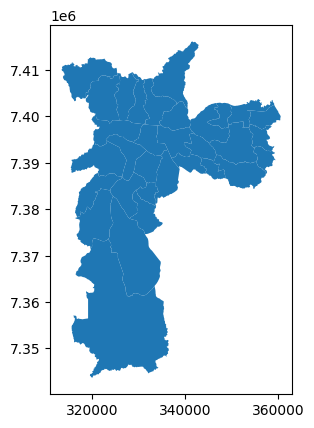

In [575]:
subprefeituras.plot()

In [576]:
def save_graph(fig, fname: str) -> str:

    fpath = os.path.join(GRAFICOS_FOLDER, fname)
    fig.savefig(fpath, format='png', bbox_inches='tight')

    return fpath


In [577]:
df = pd.read_csv(DADOS_FINAL, sep=';')

In [578]:
df.head()

,exercicio,cod_emenda,direta_ou_indireta,cod_orgao,cod_unidade,cod_programa,cod_funcao,cod_subfuncao,cod_proj_atividade,cod_fonte,...,desc_distrito,tipo_regionalizacao,valor_regionalizado,cod_vereador,motivo_emenda,apelido,cod_partido,sigla_partido,nome_partido,_merge
0,2025,3514,Administraçăo Direta,60,10,3001,13,392,9222,0,...,Supra-Distrital,Despesa Não-Regionalizável,1000.0,1814,Esta emenda visa atender as necessidades das s...,MILTON LEITE,111,UNIÃO,UNIÃO BRASIL,both
1,2025,1791,Administraçăo Direta,60,10,3022,15,452,9241,0,...,Supra-Distrital,Despesa Não-Regionalizável,2000000.0,1789,Trata-se de antiga reivindicação da comunidade...,ARSELINO TATTO,13,PT,PARTIDO DOS TRABALHADORES,both
2,2025,3514,Administraçăo Direta,60,10,3017,27,812,9223,0,...,Supra-Distrital,Despesa Não-Regionalizável,1000.0,1814,Esta emenda visa atender as necessidades das s...,MILTON LEITE,111,UNIÃO,UNIÃO BRASIL,both
3,2025,3549,Administraçăo Direta,20,10,3009,26,453,9145,0,...,Supra-Distrital,Despesa Não-Regionalizável,100000.0,1805,A presente emenda visa a melhoria na infraestr...,SIDNEY CRUZ,15,MDB,MOVIMENTO DEMOCRÁTICO BRASILEIRO,both
4,2025,3533,Administraçăo Direta,20,10,3009,26,572,9138,0,...,Supra-Distrital,Despesa Não-Regionalizável,30000.0,1805,A presente emenda destina-se a reestruturar a ...,SIDNEY CRUZ,15,MDB,MOVIMENTO DEMOCRÁTICO BRASILEIRO,both


In [579]:
df.dtypes

exercicio                int64
cod_emenda               int64
direta_ou_indireta      object
cod_orgao                int64
cod_unidade              int64
cod_programa             int64
cod_funcao               int64
cod_subfuncao            int64
cod_proj_atividade       int64
cod_fonte                int64
desc_orgao              object
desc_unidade            object
desc_programa           object
desc_funcao             object
desc_subfuncao          object
desc_proj_atividade     object
desc_fonte              object
valor_orcado             int64
index                   object
cod_regiao               int64
cod_subprefeitura        int64
cod_distrito             int64
desc_regiao             object
desc_subprefeitura      object
desc_distrito           object
tipo_regionalizacao     object
valor_regionalizado    float64
cod_vereador             int64
motivo_emenda           object
apelido                 object
cod_partido              int64
sigla_partido           object
nome_par

In [580]:
df.shape

(1076, 34)

In [581]:
df[['exercicio', 'cod_emenda', 'cod_proj_atividade', 'cod_orgao', 'cod_unidade', 'cod_subprefeitura']].duplicated().sum()

np.int64(0)

In [582]:
#identifica o total de emendas
df['index'] = df['exercicio'].astype(str) + '.' + df['cod_orgao'].astype(str) + '.' \
    + df['cod_unidade'].astype(str) +  '.' + df['cod_proj_atividade'].astype(str)

### Analise descritiva

os graficos a seguir tem por objetivo contextualizar a base de daods.

In [583]:
numero_total_de_emendas = df['index'].nunique()

print('O numero total de emendas é', numero_total_de_emendas)

O numero total de emendas é 1021


In [584]:
print('O numero total de regionalizacoes distintas das emendas é', len(df))

O numero total de regionalizacoes distintas das emendas é 1076


In [585]:
print(f'Em média, cada emenda teve {numero_total_de_emendas/len(df)} regionalizações no período')

Em média, cada emenda teve 0.9488847583643123 regionalizações no período


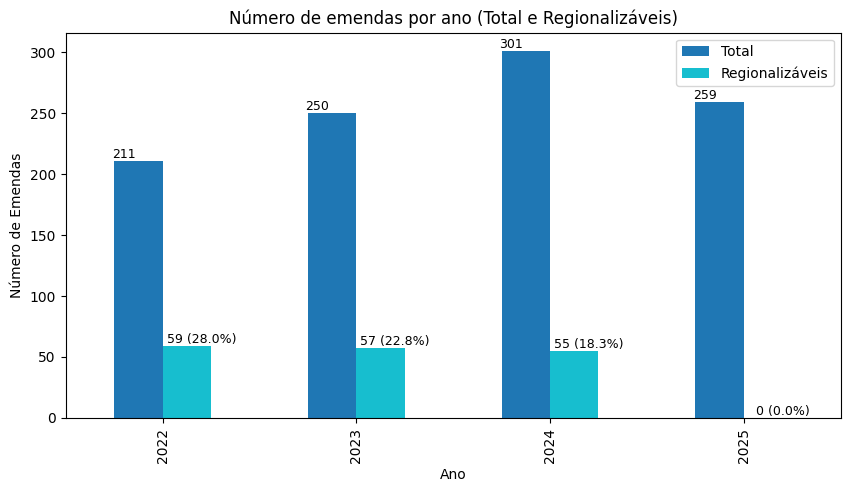

In [586]:
# Agrupa os dados por ano e calcula o total de emendas e emendas regionalizáveis
total_emendas = df.groupby('exercicio')['index'].nunique()
regionalizaveis = df[df['tipo_regionalizacao'] != 'Despesa Não-Regionalizável'].groupby('exercicio')['index'].nunique()

# Cria um DataFrame para facilitar o plot
data = pd.DataFrame({'Total': total_emendas, 'Regionalizáveis': regionalizaveis}).fillna(0)

# Plota as barras lado a lado
ax = data.plot(kind='bar', figsize=(10, 5), title='Número de emendas por ano (Total e Regionalizáveis)', colormap='tab10')

# Adiciona anotações às barras
for i, (total, regional) in enumerate(zip(data['Total'], data['Regionalizáveis'])):
    # Anota o valor total de emendas
    ax.annotate(f'{total}', (i - 0.2, total), ha='center', va='bottom', fontsize=9, color='black')
    # Calcula o percentual regionalizável
    percentage = (regional / total) * 100 if total > 0 else 0
    # Anota o valor regionalizável
    ax.annotate(f'{regional:.0f} ({percentage:.1f}%)', (i + 0.2, regional), ha='center', va='bottom', fontsize=9, color='black')

# Ajusta o layout e salva o gráfico
ax.set_ylabel('Número de Emendas')
ax.set_xlabel('Ano')
fig = ax.get_figure()
save_graph(fig, 'emendas_total_vs_regionalizaveis.png')

plt.show()

In [587]:
df['sigla_partido'].unique()

array(['UNIÃO', 'PT', 'MDB', 'NOVO', 'PSD', 'PSOL', 'PSB', 'PV',
       'REPUBLICANOS', 'PL', 'SOLIDARIEDADE', 'PP', 'PSDB', 'PODE', 'PTB',
       'PSL', 'DEM'], dtype=object)

In [588]:
espectro_partidos = {
                    'UNIÃO' : 'direita', 
                    'PT' : 'esquerda', 
                    'MDB' : 'centro', 
                    'NOVO' : 'direita', 
                    'PSD' : 'centro', 
                    'PSOL' : 'esquerda', 
                    'PSB' : 'esquerda', 
                    'PV' : 'esquerda', # esta junto com o PT na federação
                    'REPUBLICANOS' : 'direita', 
                    'PL' : 'direita', 
                    'SOLIDARIEDADE' : 'centro', 
                    'PP' : 'direita', 
                    'PSDB' : 'centro', 
                    'PODE' : 'centro', 
                    'PTB' : 'centro',
                    'PSL' : 'direita', 
                    'DEM' : 'direita'
                    }

In [589]:
df['espectro_partido'] = df['sigla_partido'].map(espectro_partidos)

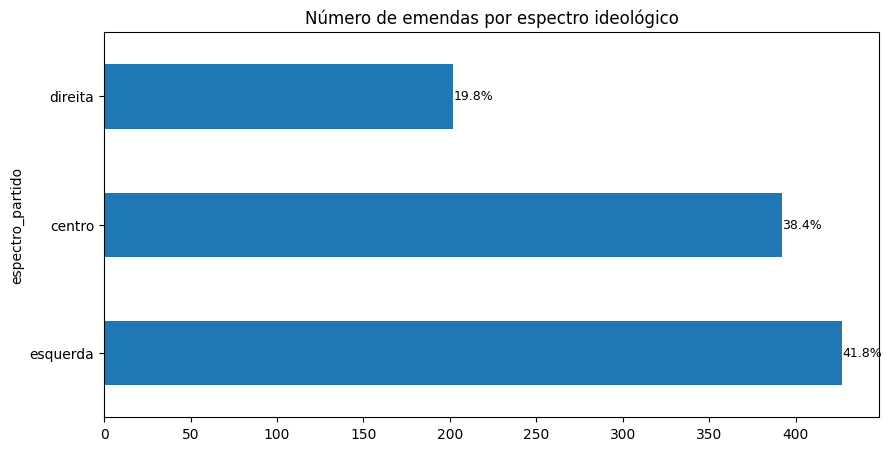

In [590]:
# Ordena os dados pela contagem de emendas em ordem decrescente
data = df.groupby('espectro_partido')['index'].nunique().sort_values(ascending=False)

# Calcula o total de emendas
total = df['index'].nunique()

# Plota o gráfico de barras horizontais
ax = data.plot.barh(title='Número de emendas por espectro ideológico', figsize=(10, 5))

# Ajusta o espaçamento entre as barras
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data.index, fontsize=10)

# Adiciona os percentuais como anotações
for i, (value, label) in enumerate(zip(data, data.index)):
    percentage = (value / total) * 100
    ax.annotate(f'{percentage:.1f}%', (value, i), ha='left', va='center', fontsize=9)

# Salva o gráfico
fig = ax.get_figure()
save_graph(fig, 'emendas_por_espectro_ordenadas.png')

plt.show()

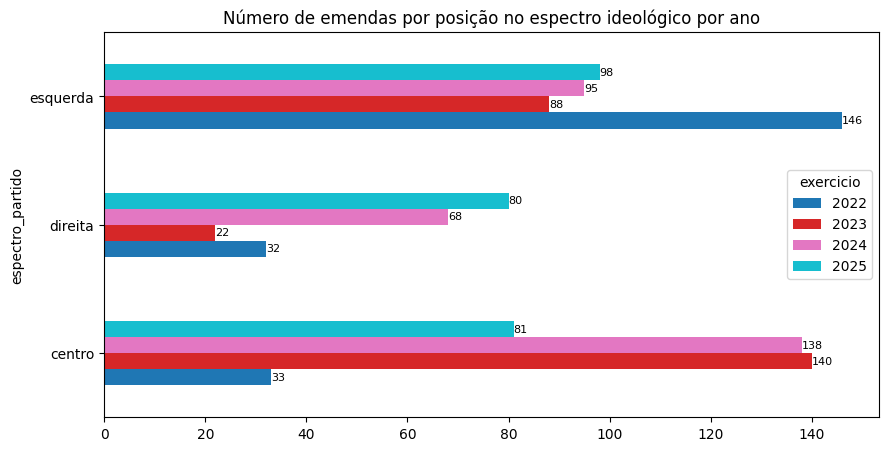

In [591]:
# Pivot the data to have 'exercicio' as columns and 'sigla_partido' as index
pivot_df = df.pivot_table(index='espectro_partido', columns='exercicio', values='index', aggfunc='nunique', fill_value=0)

# Plot the data as a grouped bar chart
ax = pivot_df.plot(kind='barh', figsize=(10, 5), title='Número de emendas por posição no espectro ideológico por ano', colormap='tab10')

# Adjust the y-axis limit
ax.set_ylim(-0.5, len(pivot_df.index) - 0.5)  # Ensures all bars are fully visible

# Add annotations to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8)

# Save the graph
fig = ax.get_figure()
save_graph(fig, 'emendas_por_espectro_ano_agrupadas.png')

plt.show()

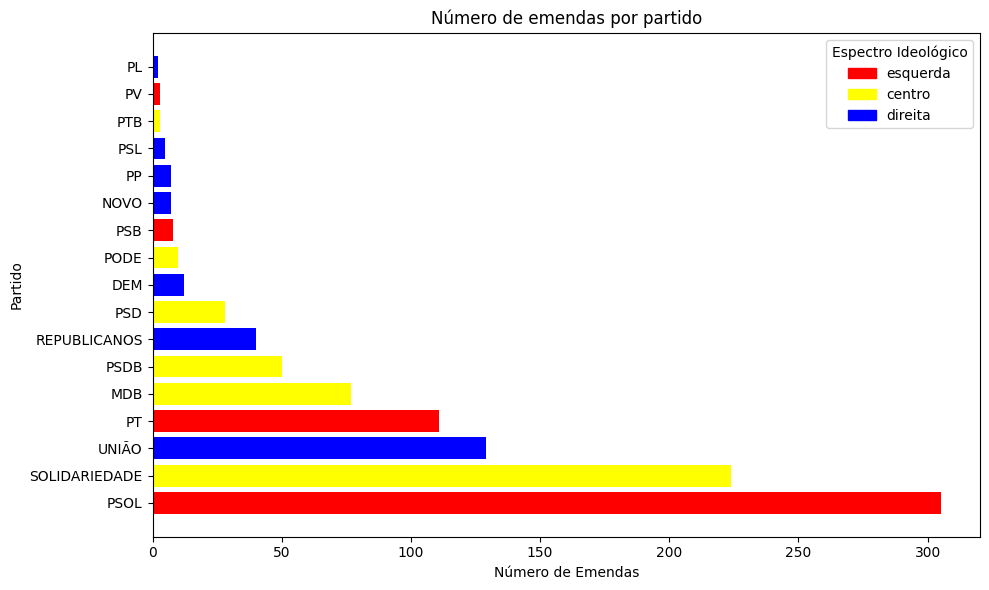

In [592]:
# Agrupa os dados por partido e espectro ideológico
data = df.groupby(['sigla_partido', 'espectro_partido'])['index'].nunique().reset_index()

# Ordena os dados pela contagem de emendas em ordem decrescente
data = data.sort_values(by='index', ascending=False)

# Define as cores para cada espectro ideológico
colors = {'esquerda': 'red', 'centro': 'yellow', 'direita': 'blue'}

# Plota o gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(data['sigla_partido'], data['index'], color=data['espectro_partido'].map(colors))

# Adiciona a legenda
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors.values()]
labels = colors.keys()
ax.legend(handles, labels, title='Espectro Ideológico')

# Configurações adicionais
ax.set_title('Número de emendas por partido')
ax.set_xlabel('Número de Emendas')
ax.set_ylabel('Partido')
plt.tight_layout()

# Salva o gráfico
save_graph(fig, 'emendas_por_partido_espectro_horizontal.png')

plt.show()

## Análise exploratória

Vamos gerar os seguintes gráficos:

1. grafico de pizza com o total de regionalizadas versus nao regionalziadas pra dar a visao do todo
2. mapa coropletico com a quantidade de emendas por subprefeitura, independentemente do partido e do ano
3. por posicao no espectro, mapa com o percentual de emendas por subprefeitura
4. analise LISA para identificar clusters espaciais da posicao no espectro - final da discussao
5. (plus) - fazer a categorizacao dos motivos para deixar um final aberto

In [593]:
df['tipo_regionalizacao'].unique()

array(['Despesa Não-Regionalizável', 'Despesa Regionalizável'],
      dtype=object)

In [594]:
df['tipo_regionalizacao'].isnull().any()

np.False_

In [595]:
df.groupby('tipo_regionalizacao')['index'].nunique()

tipo_regionalizacao
Despesa Não-Regionalizável    905
Despesa Regionalizável        171
Name: index, dtype: int64

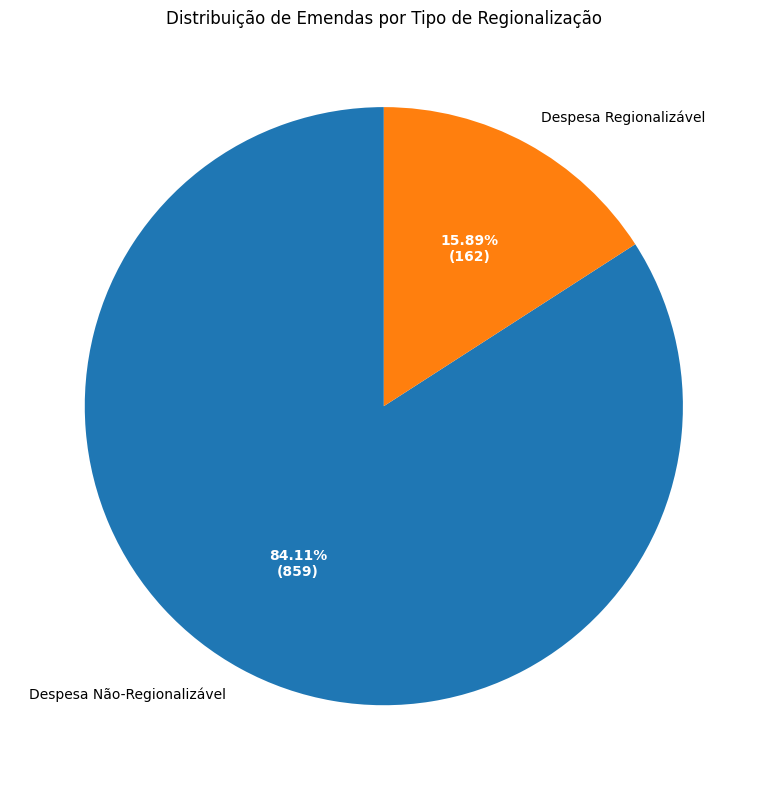

In [596]:
# Agrupa os dados por tipo de regionalização e calcula o total de emendas
data = df.groupby('tipo_regionalizacao')['index'].nunique()
total_emendas = df['index'].nunique()

# Cria o gráfico de pizza
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    data,
    labels=data.index,
    autopct=lambda pct: f'{pct:.2f}%\n({round(pct * total_emendas / 100):,})',  # Corrigido para evitar erro de arredondamento
    startangle=90,
    colors=plt.cm.tab10.colors
)

# Configurações adicionais
ax.set_title('Distribuição de Emendas por Tipo de Regionalização')
plt.setp(autotexts, size=10, weight='bold', color='white')
plt.tight_layout()

# Salva o gráfico
save_graph(fig, 'grafico_pizza_tipo_regionalizacao.png')

plt.show()

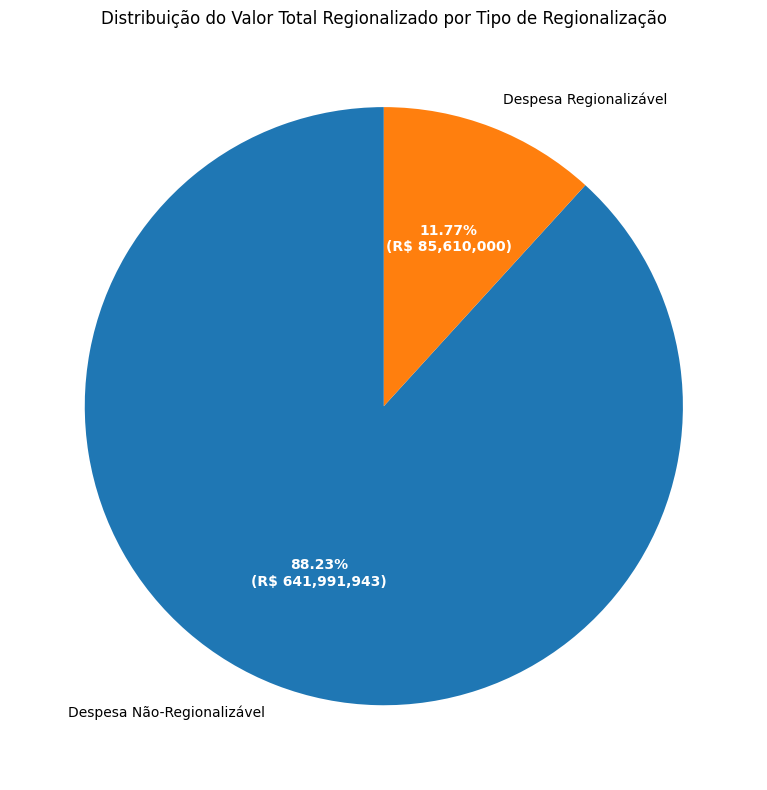

In [597]:
# Agrupa os dados por tipo de regionalização e calcula o valor total regionalizado
data = df.groupby('tipo_regionalizacao')['valor_orcado'].sum()
total_valor = data.sum()

# Cria o gráfico de pizza
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    data,
    labels=data.index,
    autopct=lambda pct: f'{pct:.2f}%\n(R$ {round(pct * total_valor / 100):,})',
    startangle=90,
    colors=plt.cm.tab10.colors
)

# Configurações adicionais
ax.set_title('Distribuição do Valor Total Regionalizado por Tipo de Regionalização')
plt.setp(autotexts, size=10, weight='bold', color='white')
plt.tight_layout()

# Salva o gráfico
save_graph(fig, 'grafico_pizza_valor_total_regionalizado.png')

plt.show()

In [598]:
# Padroniza os nomes para maiúsculas e remove espaços extras
df['desc_subprefeitura'] = df['desc_subprefeitura'].str.replace('Subprefeitura ', '')
df['desc_subprefeitura'] = df['desc_subprefeitura'].str.upper().str.strip()

# Substitui caracteres especiais e ajusta nomes para corresponder ao padrão de subprefeituras['nm_subpref']
df['desc_subprefeitura'] = df['desc_subprefeitura'].replace({
    "ARICANDUVA/FORMOSA/CARRÃO": "ARICANDUVA-FORMOSA-CARRAO",
    "BUTANTÃ": "BUTANTA",
    "CIDADE ADEMAR": "CIDADE ADEMAR",
    "CIDADE TIRADENTES": "CIDADE TIRADENTES",
    "FREGUESIA/BRASILÂNDIA": "FREGUESIA-BRASILANDIA",
    "JACANÃ/TREMEMBÉ": "JACANA-TREMEMBE",
    "M'BOI MIRIM": "M BOI MIRIM",
    "PIRITUBA/JARAGUÁ": "PIRITUBA-JARAGUA",
    "SANTANA/TUCURUVI": "SANTANA-TUCURUVI",
    "SÃO MIGUEL": "SAO MIGUEL",
    "VILA MARIA/VILA GUILHERME": "VILA MARIA-VILA GUILHERME",
    "VILA PRUDENTE": "VILA PRUDENTE",
    'CASA VERDE/CACHOEIRINHA' : 'CASA VERDE-CACHOEIRINHA',
    'DE GUAIANASES' : 'GUAIANASES',
    'DE VILA PRUDENTE' : 'VILA PRUDENTE',
    'SÃO MATEUS' : 'SAO MATEUS',
    'SÃO MIGUEL PAULISTA' : 'SAO MIGUEL',
    'SÉ' : 'SE'
})

In [599]:
df_reg = df[df['tipo_regionalizacao'] != 'Despesa Não-Regionalizável'].reset_index(drop=True).copy()

In [600]:
set(df['desc_subprefeitura'])-set(subprefeituras['nm_subpref'])

{'SUPRA SUBPREFEITURA'}

Algumas subprefeituras não receberam nenhuma emenda.

In [601]:
set(subprefeituras['nm_subpref']) - set(df['desc_subprefeitura'])

{'ERMELINO MATARAZZO',
 'JACANA-TREMEMBE',
 'PERUS',
 'PINHEIROS',
 'SANTANA-TUCURUVI'}

In [602]:
subprefeituras.columns

Index(['cd_identif', 'cd_subpref', 'nm_subpref', 'tx_escala', 'sg_fonte_o',
       'dt_criacao', 'cd_tipo_di', 'dt_atualiz', 'cd_usuario', 'sg_subpref',
       'qt_area_qu', 'qt_area_me', 'geometry'],
      dtype='object')

In [603]:
subprefeituras = subprefeituras[['nm_subpref', 'sg_subpref', 'geometry']].rename(columns={
    'nm_subpref': 'desc_subprefeitura',
    'sg_subpref': 'sigla_subprefeitura'
})

In [604]:
subprefeituras.head()

,desc_subprefeitura,sigla_subprefeitura,geometry
0,FREGUESIA-BRASILANDIA,FO,"POLYGON ((327340.628 7399133.313, 327331.514 7..."
1,CASA VERDE-CACHOEIRINHA,CV,"POLYGON ((329084.795 7402363.669, 329086.123 7..."
2,LAPA,LA,"POLYGON ((321633.729 7393535.365, 321633.031 7..."
3,PERUS,PR,"POLYGON ((325464.932 7409329.344, 325464.513 7..."
4,SE,SE,"POLYGON ((330197.017 7396087.885, 330211.849 7..."


In [605]:
df_reg['desc_subprefeitura'].isnull().any()

np.False_

In [606]:
subprefeituras['desc_subprefeitura'].isnull().any()

np.False_

In [607]:
df_reg = pd.merge(df_reg, subprefeituras[['desc_subprefeitura', 'sigla_subprefeitura']], on='desc_subprefeitura', how='left')

In [608]:
df_subs = df_reg[df_reg['desc_subprefeitura'].notnull()]
df_subs['sigla_subprefeitura'].isnull().any()

np.False_

In [609]:
df_subs['desc_subprefeitura'].unique()

array(['LAPA', 'SE', 'BUTANTA', 'VILA MARIANA', 'IPIRANGA', 'SANTO AMARO',
       'JABAQUARA', 'CIDADE ADEMAR', 'CAMPO LIMPO', 'M BOI MIRIM',
       'CAPELA DO SOCORRO', 'PARELHEIROS', 'PENHA', 'SAO MIGUEL',
       'ITAIM PAULISTA', 'MOOCA', 'ARICANDUVA-FORMOSA-CARRAO', 'ITAQUERA',
       'VILA PRUDENTE', 'SAO MATEUS', 'CIDADE TIRADENTES', 'SAPOPEMBA',
       'PIRITUBA-JARAGUA', 'FREGUESIA-BRASILANDIA',
       'VILA MARIA-VILA GUILHERME', 'CASA VERDE-CACHOEIRINHA',
       'GUAIANASES'], dtype=object)

In [610]:
len(df_subs)==df_reg.shape[0]

True

In [611]:
qtd_reigonaliz_subs = df_subs.groupby('desc_subprefeitura').count()['exercicio'].reset_index()
qtd_reigonaliz_subs.columns = ['desc_subprefeitura', 'qtd_regionalizacoes']
qtd_reigonaliz_subs.head()

,desc_subprefeitura,qtd_regionalizacoes
0,ARICANDUVA-FORMOSA-CARRAO,4
1,BUTANTA,5
2,CAMPO LIMPO,4
3,CAPELA DO SOCORRO,24
4,CASA VERDE-CACHOEIRINHA,8


In [612]:
qtd_reigonaliz_subs = pd.merge(qtd_reigonaliz_subs, subprefeituras[['desc_subprefeitura', 'geometry']], 
                               on='desc_subprefeitura', how='right')

In [613]:
qtd_reigonaliz_subs.head()

,desc_subprefeitura,qtd_regionalizacoes,geometry
0,FREGUESIA-BRASILANDIA,2.0,"POLYGON ((327340.628 7399133.313, 327331.514 7..."
1,CASA VERDE-CACHOEIRINHA,8.0,"POLYGON ((329084.795 7402363.669, 329086.123 7..."
2,LAPA,3.0,"POLYGON ((321633.729 7393535.365, 321633.031 7..."
3,PERUS,NaN,"POLYGON ((325464.932 7409329.344, 325464.513 7..."
4,SE,2.0,"POLYGON ((330197.017 7396087.885, 330211.849 7..."


In [614]:
qtd_reigonaliz_subs = gpd.GeoDataFrame(qtd_reigonaliz_subs, geometry='geometry', crs=subprefeituras.crs)
qtd_reigonaliz_subs['qtd_regionalizacoes'].isnull().any()

np.True_

In [615]:
print(qtd_reigonaliz_subs['qtd_regionalizacoes'].isnull().sum())
qtd_reigonaliz_subs['qtd_regionalizacoes'] = qtd_reigonaliz_subs['qtd_regionalizacoes'].fillna(0)

5


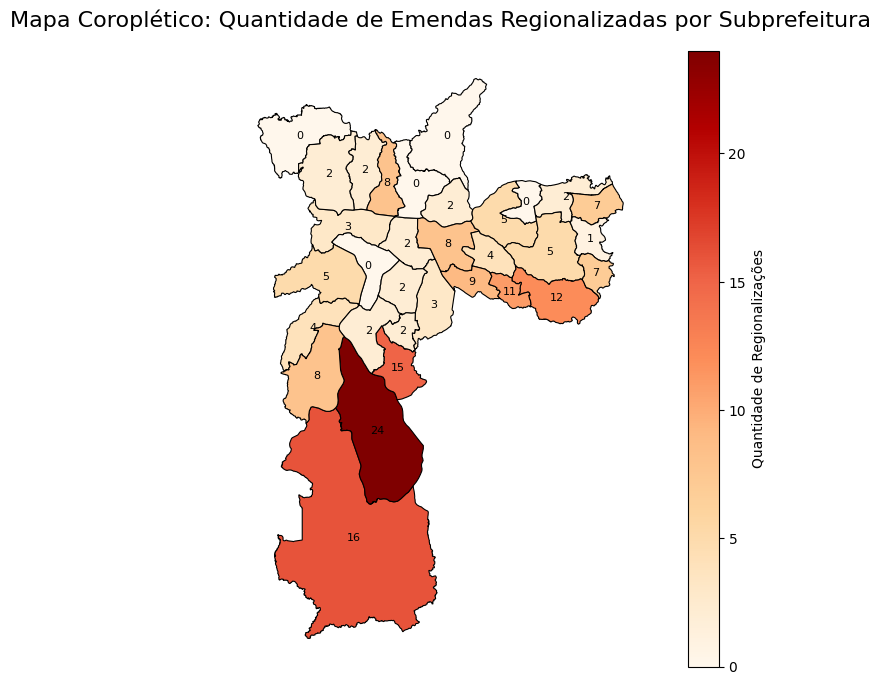

In [616]:
# Configura o tamanho do mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plota o mapa coroplético
qtd_reigonaliz_subs.plot(
    column='qtd_regionalizacoes',  # Coluna para basear as cores
    cmap='OrRd',  # Paleta de cores
    linewidth=0.8,  # Largura das bordas
    edgecolor='black',  # Cor das bordas
    legend=True,  # Adiciona legenda
    legend_kwds={
        'label': "Quantidade de Regionalizações",
        'orientation': "vertical"
    },
    ax=ax
)

# Adiciona anotações com a quantidade de regionalizações dentro de cada polígono
for x, y, label in zip(
    qtd_reigonaliz_subs.geometry.centroid.x, 
    qtd_reigonaliz_subs.geometry.centroid.y, 
    qtd_reigonaliz_subs['qtd_regionalizacoes']
):
    ax.annotate(
        text=int(label),  # Texto da anotação
        xy=(x, y),  # Coordenadas do centroide
        ha='center',  # Alinhamento horizontal
        va='center',  # Alinhamento vertical
        fontsize=8,  # Tamanho da fonte
        color='black'  # Cor do texto
    )

# Adiciona título e remove os eixos
ax.set_title('Mapa Coroplético: Quantidade de Emendas Regionalizadas por Subprefeitura', fontsize=16)
ax.axis('off')

# Salva o gráfico
save_graph(fig, 'mapa_coropletico_regionalizacoes_anotado.png')

plt.show()

In [617]:
val_regionaliz_subs = df_subs.groupby('desc_subprefeitura').sum()['valor_regionalizado'].reset_index()
val_regionaliz_subs.columns = ['desc_subprefeitura', 'valor_regionalizado']
val_regionaliz_subs.head()

,desc_subprefeitura,valor_regionalizado
0,ARICANDUVA-FORMOSA-CARRAO,4000000.0
1,BUTANTA,830000.0
2,CAMPO LIMPO,1630000.0
3,CAPELA DO SOCORRO,12460000.0
4,CASA VERDE-CACHOEIRINHA,257000.0


In [618]:
val_regionaliz_subs = pd.merge(val_regionaliz_subs, subprefeituras[['desc_subprefeitura', 'geometry']], 
                               on='desc_subprefeitura', how='right')
val_regionaliz_subs = gpd.GeoDataFrame(val_regionaliz_subs, geometry='geometry', crs=subprefeituras.crs)

In [619]:
val_regionaliz_subs.head()

,desc_subprefeitura,valor_regionalizado,geometry
0,FREGUESIA-BRASILANDIA,201000.0,"POLYGON ((327340.628 7399133.313, 327331.514 7..."
1,CASA VERDE-CACHOEIRINHA,257000.0,"POLYGON ((329084.795 7402363.669, 329086.123 7..."
2,LAPA,411000.0,"POLYGON ((321633.729 7393535.365, 321633.031 7..."
3,PERUS,NaN,"POLYGON ((325464.932 7409329.344, 325464.513 7..."
4,SE,630000.0,"POLYGON ((330197.017 7396087.885, 330211.849 7..."


In [620]:
val_regionaliz_subs['valor_regionalizado'].isnull().any()

np.True_

In [621]:
val_regionaliz_subs['valor_regionalizado'] = val_regionaliz_subs['valor_regionalizado'].fillna(0)

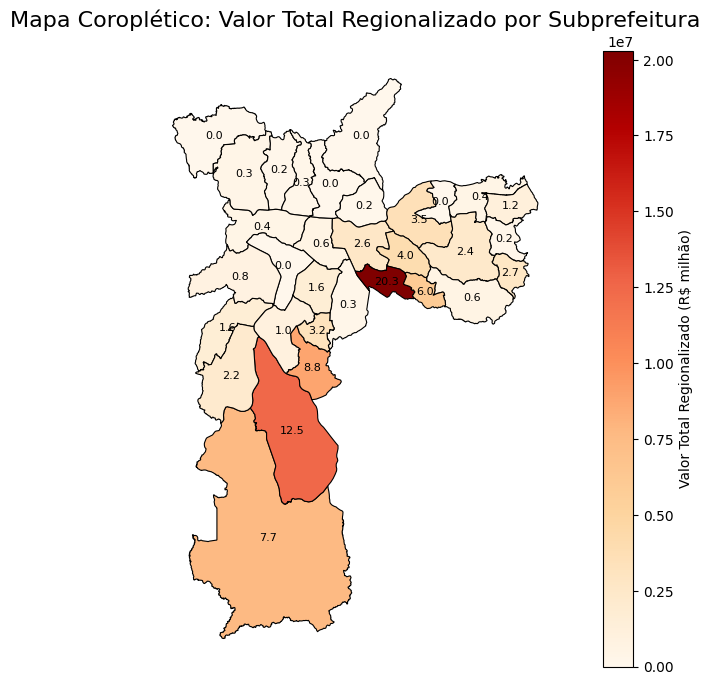

In [622]:
# Configura o tamanho do mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plota o mapa coroplético
val_regionaliz_subs.plot(
    column='valor_regionalizado',  # Coluna para basear as cores
    cmap='OrRd',  # Paleta de cores
    linewidth=0.8,  # Largura das bordas
    edgecolor='black',  # Cor das bordas
    legend=True,  # Adiciona legenda
    legend_kwds={
        'label': "Valor Total Regionalizado (R$ milhão)",  # Atualizado para incluir a unidade
        'orientation': "vertical"
    },
    ax=ax
)

# Adiciona anotações com o valor total regionalizado dentro de cada polígono
for x, y, label in zip(
    val_regionaliz_subs.geometry.centroid.x, 
    val_regionaliz_subs.geometry.centroid.y, 
    val_regionaliz_subs['valor_regionalizado']
):
    ax.annotate(
        text=f'{label / 1000000:.1f}',  # Texto da anotação formatado em R$ milhão
        xy=(x, y),  # Coordenadas do centroide
        ha='center',  # Alinhamento horizontal
        va='center',  # Alinhamento vertical
        fontsize=8,  # Tamanho da fonte
        color='black'  # Cor do texto
    )

# Adiciona título e remove os eixos
ax.set_title('Mapa Coroplético: Valor Total Regionalizado por Subprefeitura', fontsize=16)
ax.axis('off')

# Salva o gráfico
save_graph(fig, 'mapa_coropletico_valor_regionalizacoes_anotado.png')

plt.show()

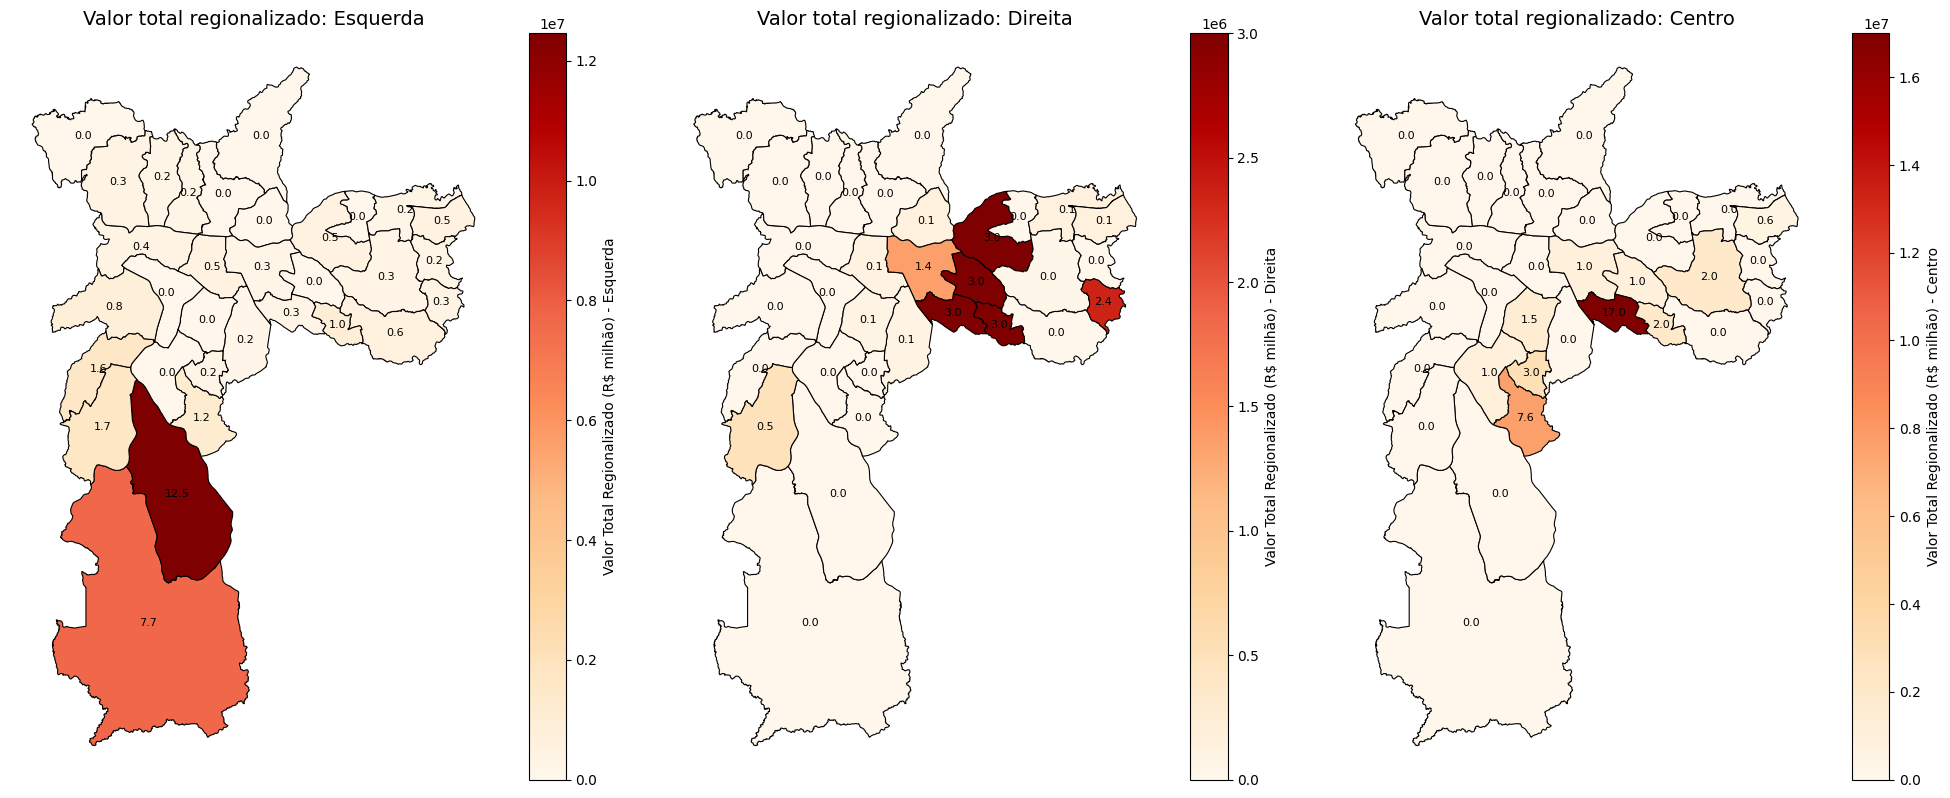

In [623]:
# Configura o tamanho do mapa com dois gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Itera sobre cada espectro político e o respectivo eixo
for ax, espectro in zip(axes, df_subs['espectro_partido'].unique()):
    # Filtra os dados para o espectro atual
    val_regionaliz_subs_espectro = df_subs[df_subs['espectro_partido'] == espectro]
    val_regionaliz_subs_espectro = val_regionaliz_subs_espectro.groupby('desc_subprefeitura').sum()['valor_regionalizado'].reset_index()
    val_regionaliz_subs_espectro.columns = ['desc_subprefeitura', 'valor_regionalizado']
    val_regionaliz_subs_espectro = pd.merge(val_regionaliz_subs_espectro, subprefeituras[['desc_subprefeitura', 'geometry']], 
                                            on='desc_subprefeitura', how='right')
    val_regionaliz_subs_espectro = gpd.GeoDataFrame(val_regionaliz_subs_espectro, geometry='geometry', crs=subprefeituras.crs)
    val_regionaliz_subs_espectro['valor_regionalizado'] = val_regionaliz_subs_espectro['valor_regionalizado'].fillna(0)

    # Plota o mapa coroplético
    val_regionaliz_subs_espectro.plot(
        column='valor_regionalizado',  # Coluna para basear as cores
        cmap='OrRd',  # Paleta de cores
        linewidth=0.8,  # Largura das bordas
        edgecolor='black',  # Cor das bordas
        legend=True,  # Adiciona legenda
        legend_kwds={
            'label': f"Valor Total Regionalizado (R$ milhão) - {espectro.capitalize()}",
            'orientation': "vertical"
        },
        ax=ax
    )

    # Adiciona anotações com o valor total regionalizado dentro de cada polígono
    for x, y, label in zip(
        val_regionaliz_subs_espectro.geometry.centroid.x, 
        val_regionaliz_subs_espectro.geometry.centroid.y, 
        val_regionaliz_subs_espectro['valor_regionalizado']
    ):
        ax.annotate(
            text=f'{label / 1000000:.1f}',  # Texto da anotação formatado em R$ milhão
            xy=(x, y),  # Coordenadas do centroide
            ha='center',  # Alinhamento horizontal
            va='center',  # Alinhamento vertical
            fontsize=8,  # Tamanho da fonte
            color='black'  # Cor do texto
        )

    # Adiciona título e remove os eixos
    ax.set_title(f'Valor total regionalizado: {espectro.capitalize()}', fontsize=14)
    ax.axis('off')

# Ajusta o layout e salva o gráfico
plt.tight_layout()
save_graph(fig, 'mapa_coropletico_valor_regionalizacoes_lado_a_lado.png')

plt.show()

In [624]:
# Cria um dicionário para armazenar os GeoDataFrames por espectro
dataframes_por_espectro = {}

# Itera sobre os espectros únicos e armazena os GeoDataFrames no dicionário
for espectro in df_subs['espectro_partido'].unique():
    df_espectro = df_subs[df_subs['espectro_partido'] == espectro]
    df_espectro = df_espectro.groupby('desc_subprefeitura').sum()['valor_regionalizado'].reset_index()
    df_espectro.columns = ['desc_subprefeitura', 'valor_regionalizado']
    gdf_espectro = pd.merge(
        df_espectro,
        subprefeituras[['desc_subprefeitura', 'geometry']],
        on='desc_subprefeitura',
        how='right'
    )

    gdf_espectro['valor_regionalizado'] = gdf_espectro['valor_regionalizado'].fillna(0)

    dataframes_por_espectro[espectro] = gpd.GeoDataFrame(gdf_espectro, geometry='geometry', crs=subprefeituras.crs)

# Exemplo de acesso ao GeoDataFrame do espectro 'esquerda'
dataframes_por_espectro['esquerda'].head()

,desc_subprefeitura,valor_regionalizado,geometry
0,FREGUESIA-BRASILANDIA,200000.0,"POLYGON ((327340.628 7399133.313, 327331.514 7..."
1,CASA VERDE-CACHOEIRINHA,250000.0,"POLYGON ((329084.795 7402363.669, 329086.123 7..."
2,LAPA,410000.0,"POLYGON ((321633.729 7393535.365, 321633.031 7..."
3,PERUS,0.0,"POLYGON ((325464.932 7409329.344, 325464.513 7..."
4,SE,500000.0,"POLYGON ((330197.017 7396087.885, 330211.849 7..."


In [625]:
for gdf in dataframes_por_espectro.values():
    print(gdf.shape)

(32, 3)
(32, 3)
(32, 3)


/tmp/ipykernel_25907/2629167185.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(gdf_espectro)


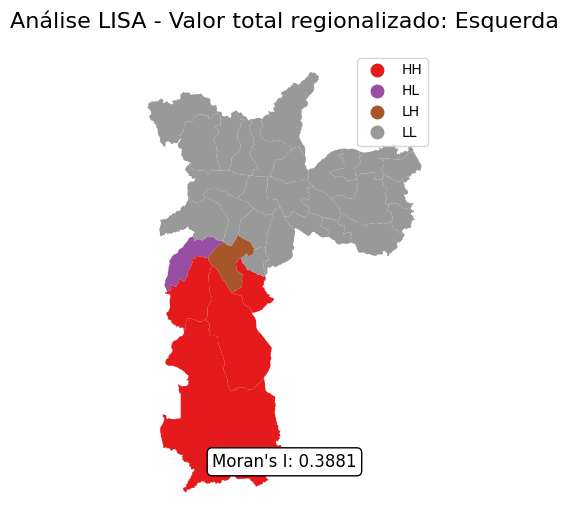

/tmp/ipykernel_25907/2629167185.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(gdf_espectro)


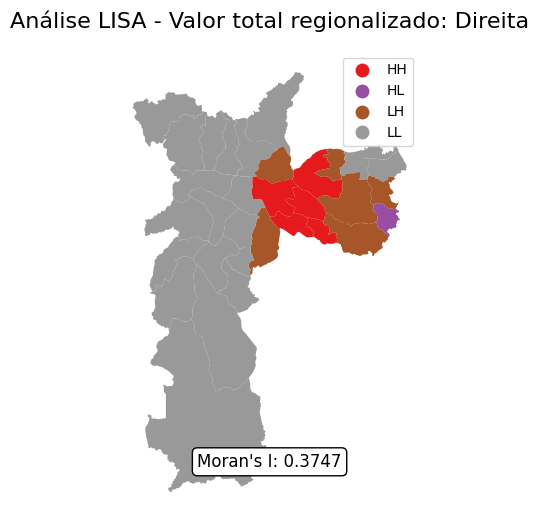

/tmp/ipykernel_25907/2629167185.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(gdf_espectro)


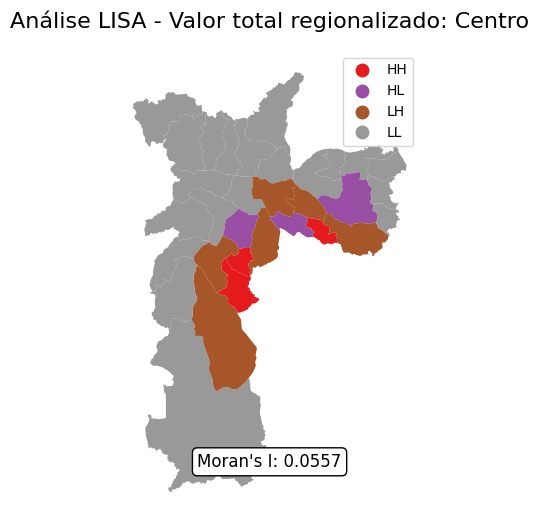

In [626]:
from esda.moran import Moran
from pysal.lib import weights

# Itera sobre cada espectro no dicionário
for espectro, gdf_espectro in dataframes_por_espectro.items():
    # Calcula a matriz de pesos espaciais baseada na vizinhança Queen
    w = weights.Queen.from_dataframe(gdf_espectro)
    w.transform = 'r'

    # Calcula o Moran's I global
    moran_global = Moran(gdf_espectro['valor_regionalizado'], w)

    # Realiza a análise LISA
    lisa = Moran_Local(gdf_espectro['valor_regionalizado'], w)

    # Adiciona os resultados ao GeoDataFrame
    gdf_espectro['LISA_Is'] = lisa.Is
    gdf_espectro['LISA_p'] = lisa.p_sim
    gdf_espectro['LISA_Cluster'] = lisa.q

    # Plota o mapa de clusters LISA
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    gdf_espectro.assign(
        LISA_Cluster=gdf_espectro['LISA_Cluster'].map({
            1: 'HH',  # High-High
            2: 'LH',  # Low-High
            3: 'LL',  # Low-Low
            4: 'HL'   # High-Low
        })
    ).plot(
        column='LISA_Cluster',
        categorical=True,
        cmap='Set1',
        legend=True,
        ax=ax
    )

    # Adiciona a anotação com o valor de Moran's I global
    ax.annotate(
        f"Moran's I: {moran_global.I:.4f}",
        xy=(0.5, 0.1),
        xycoords='axes fraction',
        ha='center',
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

    # Configurações do gráfico
    ax.set_title(f'Análise LISA - Valor total regionalizado: {espectro.capitalize()}', fontsize=16)
    ax.axis('off')

    # Salva o gráfico
    save_graph(fig, f'lisa_analysis_{espectro}.png')

    plt.show()

/tmp/ipykernel_25907/385100013.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'({percentuais[j]:.1f}%)',


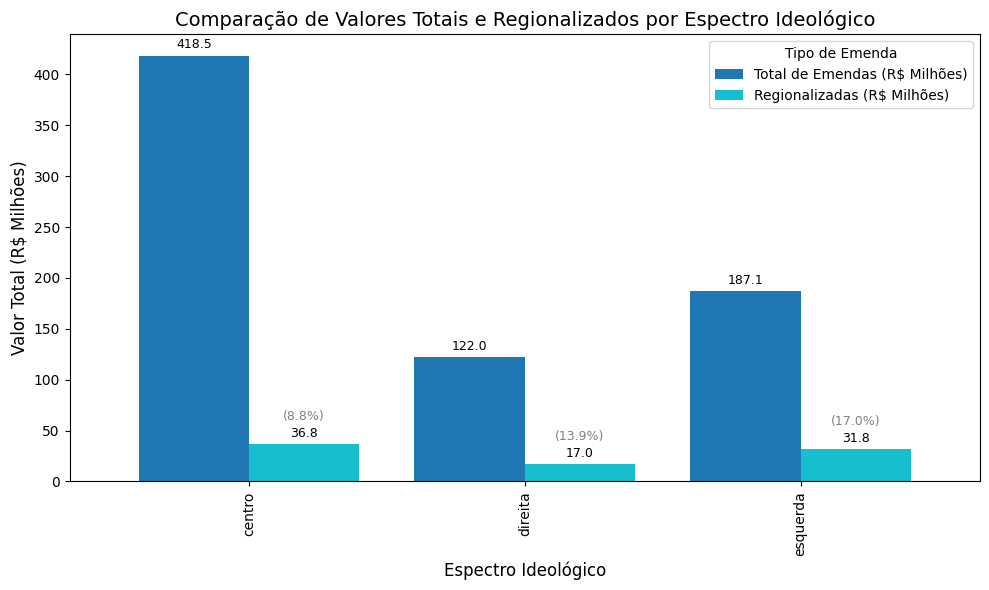

In [630]:
# Agrupa os dados por espectro e calcula os valores totais
valores_totais = df.groupby('espectro_partido')['valor_orcado'].sum() / 1e6  # Convertendo para milhões
valores_regionalizados = df_subs.groupby('espectro_partido')['valor_regionalizado'].sum() / 1e6  # Convertendo para milhões

# Calcula o percentual de valores regionalizados em relação ao total
percentuais = (valores_regionalizados / valores_totais) * 100

# Cria um DataFrame para facilitar o plot
data = pd.DataFrame({
    'Total de Emendas (R$ Milhões)': valores_totais,
    'Regionalizadas (R$ Milhões)': valores_regionalizados
}).sort_index()

# Configura o gráfico de barras agrupadas
ax = data.plot(kind='bar', figsize=(10, 6), colormap='tab10', width=0.8)

# Adiciona rótulos e título
ax.set_title('Comparação de Valores Totais e Regionalizados por Espectro Ideológico', fontsize=14)
ax.set_ylabel('Valor Total (R$ Milhões)', fontsize=12)
ax.set_xlabel('Espectro Ideológico', fontsize=12)
ax.legend(title='Tipo de Emenda', fontsize=10)

# Adiciona os valores e percentuais acima das barras
for i, container in enumerate(ax.containers):
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    # Adiciona o percentual apenas para as barras de valores regionalizados
    if i == 1:  # Índice 1 corresponde às barras de valores regionalizados
        for j, bar in enumerate(container):
            height = bar.get_height()
            ax.annotate(f'({percentuais[j]:.1f}%)', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 15),  # Offset text acima do valor
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color='gray')

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()